# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from WSMBSS import *
from general_utils import *
from visualization_utils import *
from polytope_utils import *

import warnings

warnings.filterwarnings("ignore")
# np.random.seed(100)
# %load_ext autoreload
# %autoreload 2
notebook_name = "Sparse"

# Source Generation and Mixing Scenario

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.002676549335682


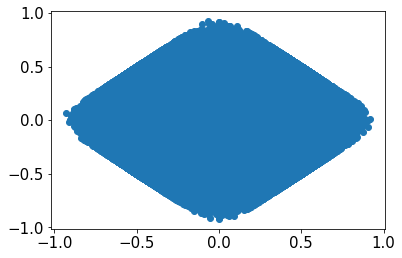

In [2]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10

S = 2 * np.random.uniform(size=(NumberofSources, int(N))) - 1
S = ProjectRowstoL1NormBall(S.T).T

A = np.random.standard_normal(size=(NumberofMixtures, NumberofSources))
X = A @ S

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise=True)
SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0, :], S[2, :])
plt.show()

In [3]:
dim = 5
signed_dims = np.array([0, 1, 2, 3, 4])
nn_dims = np.array([])
sparse_dims_list = [np.array([0, 1, 2, 3, 4])]
(Apoly, bpoly), V = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)

# Visualize Generated Sources and Mixtures

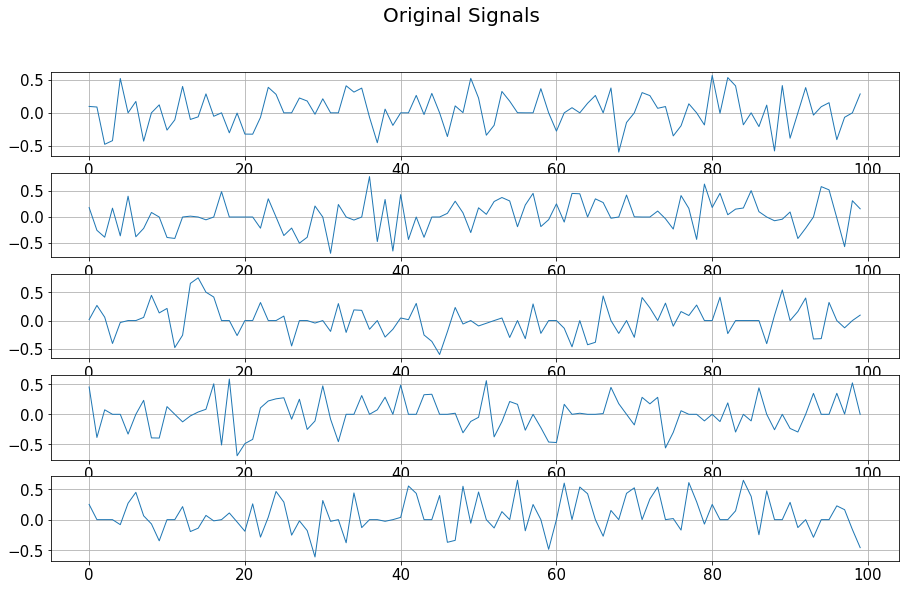

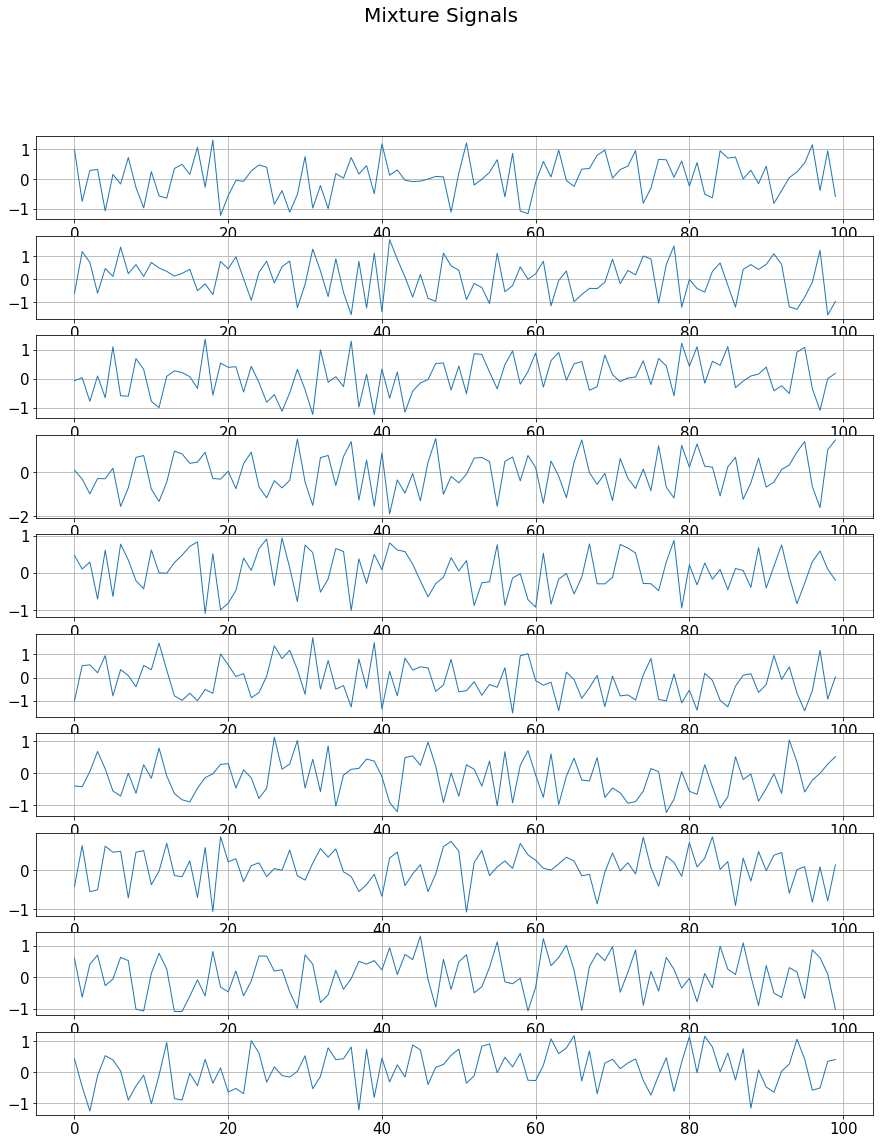

In [4]:
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    X[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
gamma_start = 0.35
gammaM_start = [gamma_start, gamma_start]
gammaM_stop = [1e-3, 1e-3]
gammaW_start = [gamma_start, gamma_start]
gammaW_stop = [1e-3, 1e-3]

OUTPUT_COMP_TOL = 1e-5
LayerGains = [1, 1]
LayerMinimumGains = [.1, .1]
LayerMaximumGains = [1e6, 1.001]
WScalings = [0.0033, 0.0033]
GamScalings = [0.01, 0.01]
zeta = 1e-4
beta = 0.5
muD = [20, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
# W_HX = np.eye(h_dim, x_dim)
# W_YH = np.eye(s_dim, h_dim)

# OPTIONS FOR synaptic_lr_rule: "constant", "divide_by_log_index", "divide_by_index"
synaptic_lr_rule = "divide_by_log_index"
# OPTIONS FOR neural_loop_lr_rule: "constant", "divide_by_loop_index", "divide_by_slow_loop_index"
neural_loop_lr_rule = "constant"

# Run WSM Algorithm on Mixture Signals

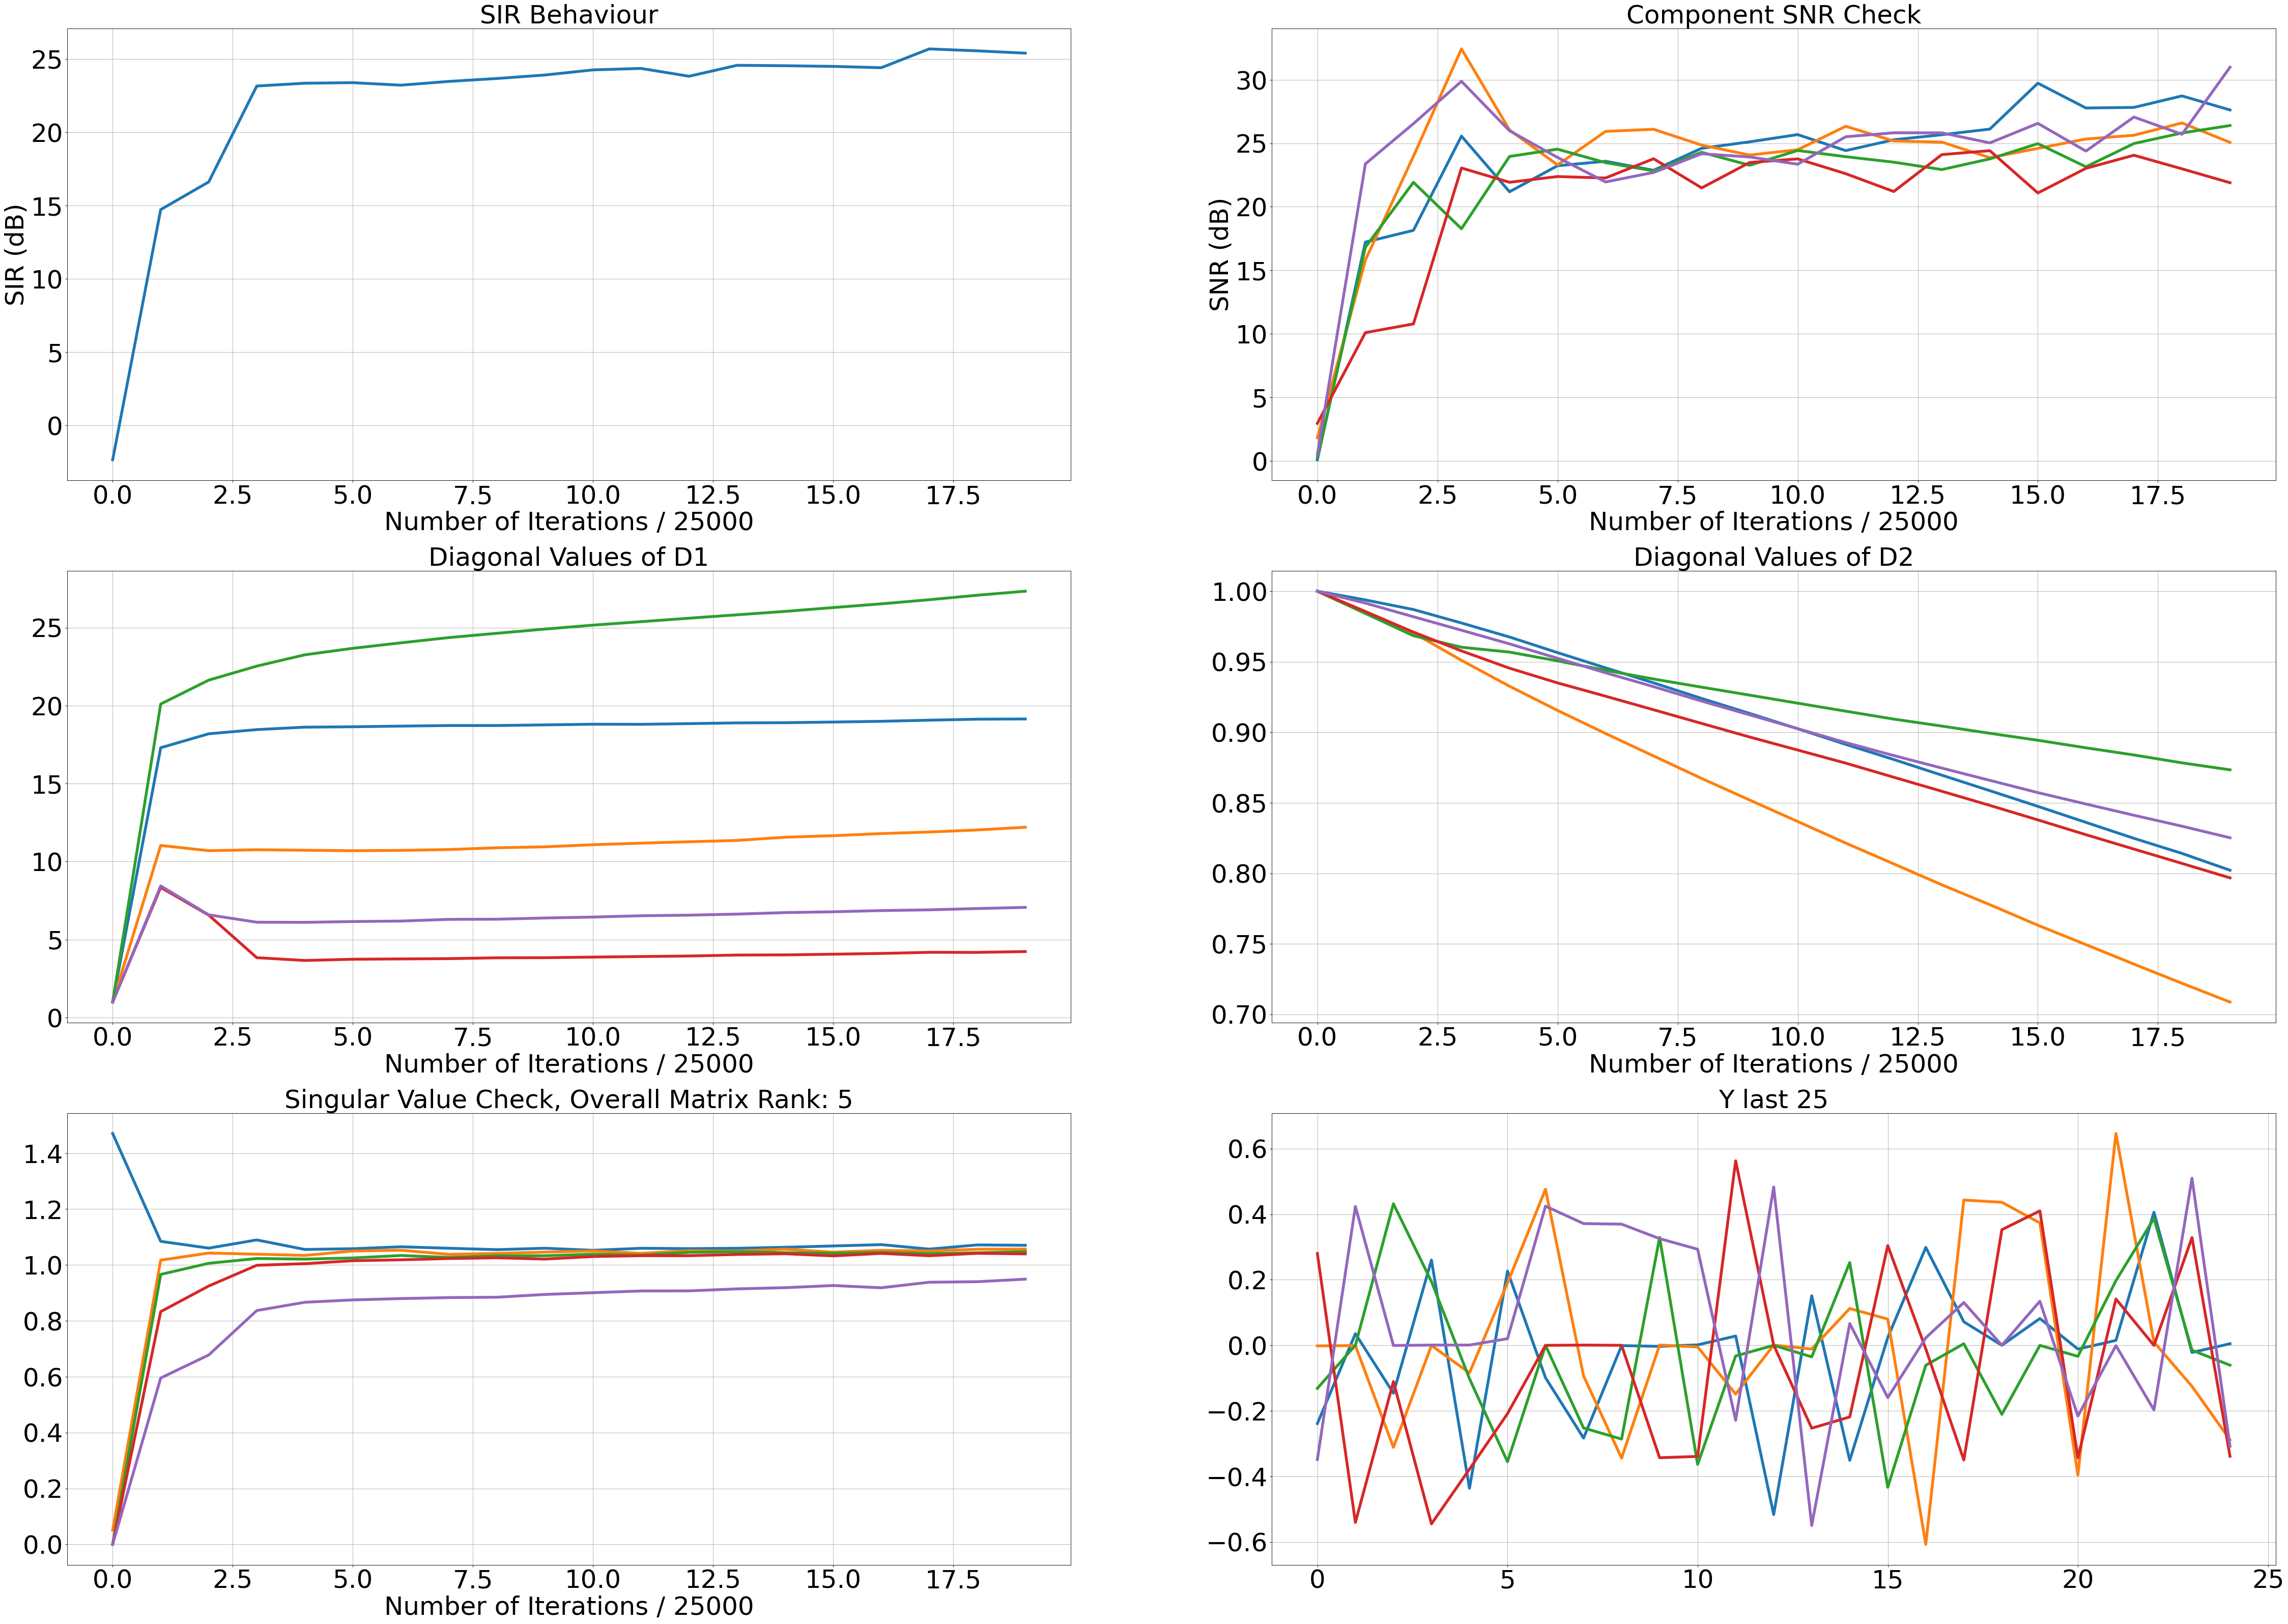

100%|██████████| 500000/500000 [08:13<00:00, 1013.36it/s]


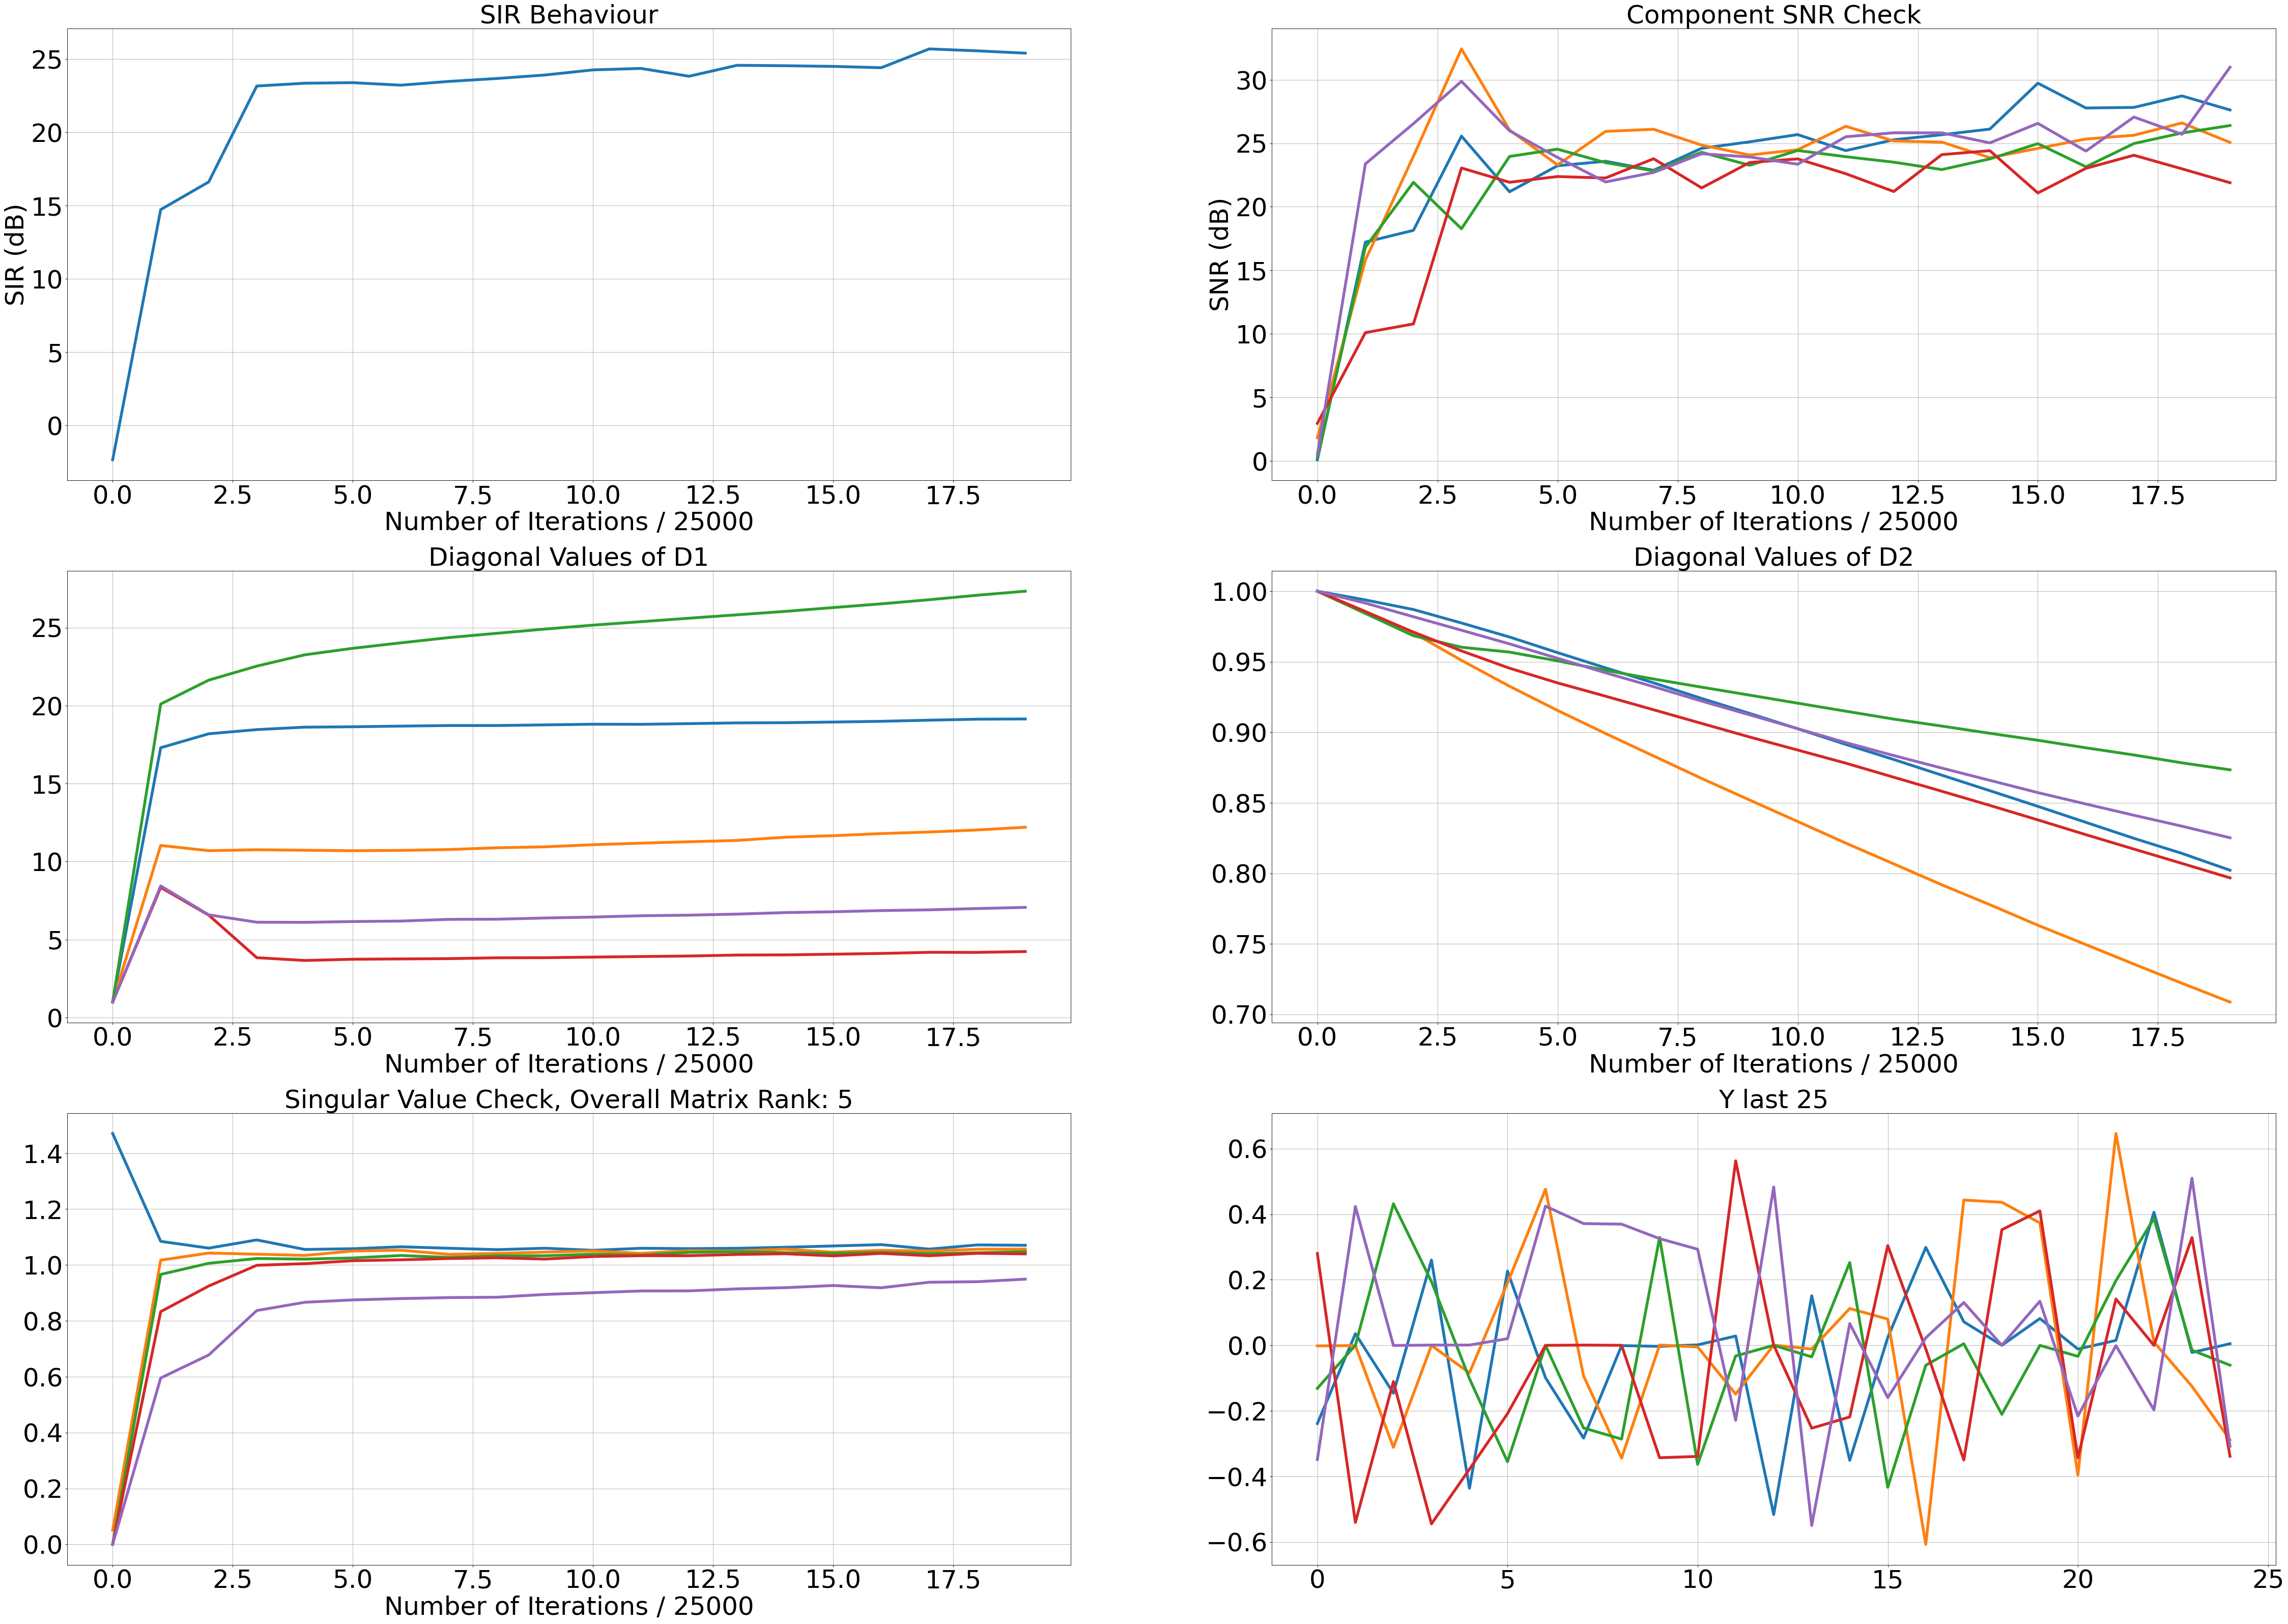

In [6]:
debug_iteration_point = 25000
modelWSM = OnlineWSMBSSCanonical(
    s_dim=s_dim,
    x_dim=x_dim,
    h_dim=h_dim,
    gammaM_start=gammaM_start,
    gammaM_stop=gammaM_stop,
    gammaW_start=gammaW_start,
    gammaW_stop=gammaW_stop,
    beta=beta,
    zeta=zeta,
    muD=muD,
    WScalings=WScalings,
    #W_HX = W_HX, W_YH = W_YH,
    DScalings=LayerGains,
    LayerMinimumGains=LayerMinimumGains,
    LayerMaximumGains=LayerMaximumGains,
    neural_OUTPUT_COMP_TOL=OUTPUT_COMP_TOL,
    set_ground_truth=True,
    S=S,
    A=A,
)

modelWSM.fit_batch(
    X,
    Apoly = Apoly,
    bpoly = bpoly,
    n_epochs=1,
    neural_lr_start=0.25,
    neural_lr_stop=0.25,
    synaptic_lr_rule=synaptic_lr_rule,
    neural_loop_lr_rule=neural_loop_lr_rule,
    clip_gain_gradients=True,
    gain_grads_clipping_multiplier = 1,
    use_newton_steps_for_gains = False,
    shuffle=False,
    debug_iteration_point=debug_iteration_point,
    plot_in_jupyter=True,
)

# Visualize SNR Convergence of Each Source Component

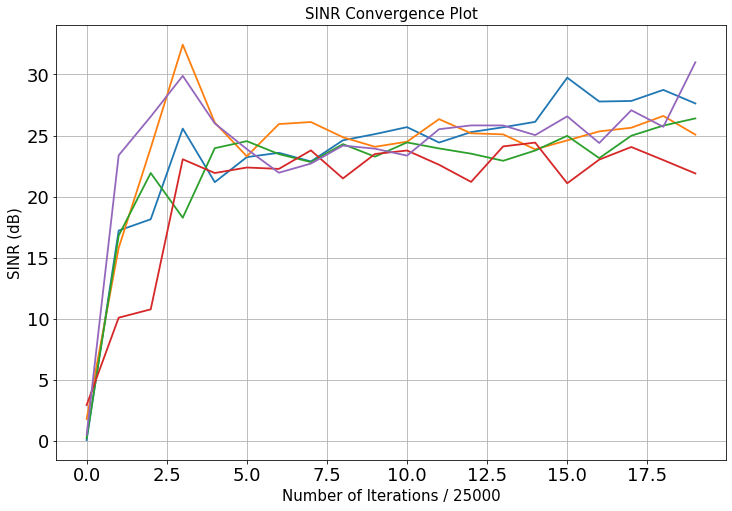

In [7]:
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
plot_convergence_plot(
    modelWSM.SNR_list,
    xlabel="Number of Iterations / {}".format(debug_iteration_point),
    ylabel="SINR (dB)",
    title="SINR Convergence Plot",
    colorcode=None,
    linewidth=1.8,
)

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Wf = modelWSM.compute_overall_mapping(return_mapping=True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10 * np.log10(CalculateSINRjit(Y_, S, False)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [27.84037023 26.75946688 25.43937547 24.69170548 27.69006858]

Overall SINR : 26.295607827117294


# Vizualize Extracted Signals Compared to Original Sources

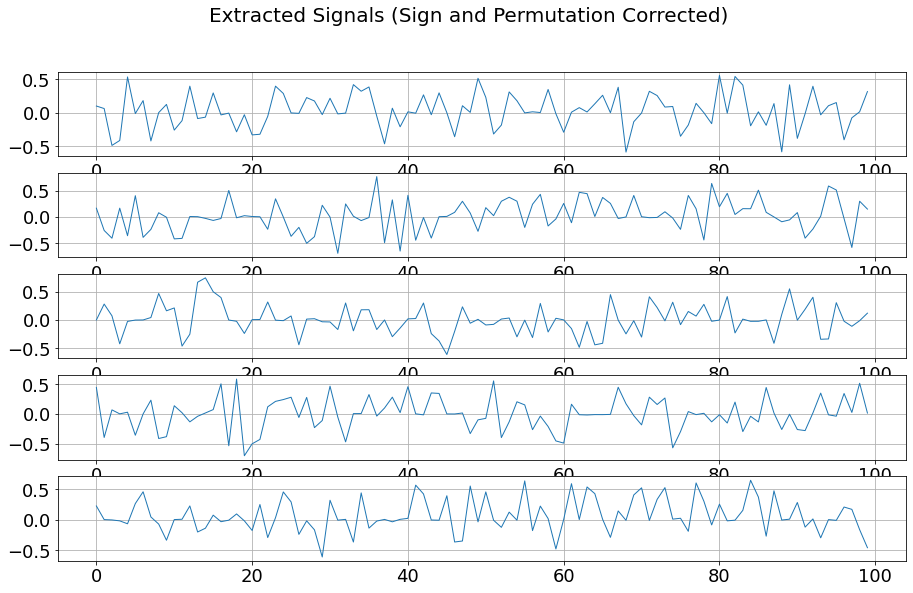

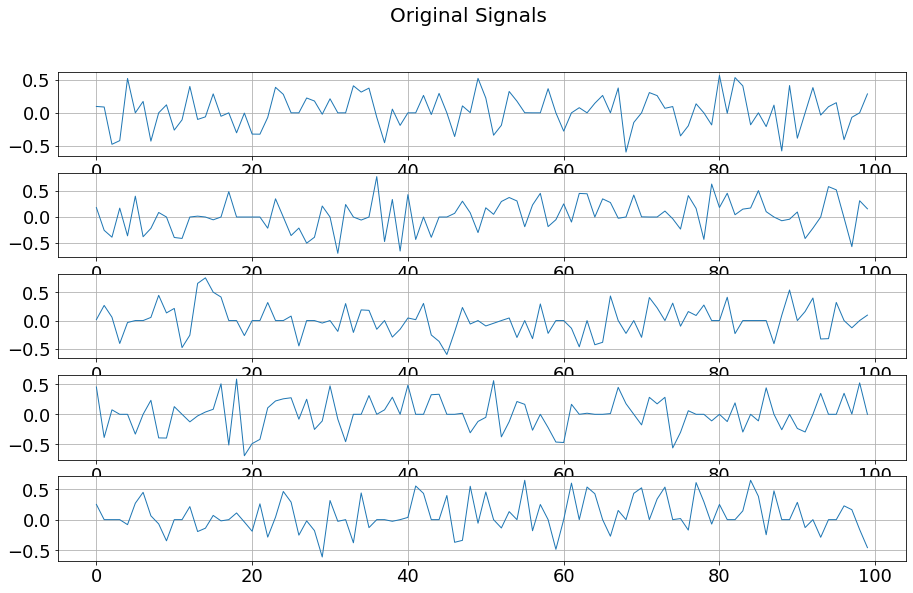

In [9]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)